In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **EDA**

In [3]:
df.isnull().sum()                   

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [8]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

In [9]:
## Dropping customerID column
df = df.drop('customerid', axis = 1)

In [10]:
df = df.dropna()

### Feature engineering

#### Tenure grouping

In [11]:
def categorize_tenure(tenure):
    if tenure <= 12:
        return 'New'
    elif tenure <= 36:
        return 'Intermediate'
    else:
        return 'Loyal'

df['tenuregroup'] = df['tenure'].apply(categorize_tenure)

#### Monthly charge per tenure

In [12]:
df['monthlychargepertenure'] = df['monthlycharges'] / (df['tenure'] + 1)

#### Encoding for yes/no columns to 1/0

In [13]:
df_encoded = df.copy()
df_encoded['partner'] = df_encoded['partner'].map({'Yes': 1, 'No': 0})
df_encoded['dependents'] = df_encoded['dependents'].map({'Yes': 1, 'No': 0})
df_encoded['phoneservice'] = df_encoded['phoneservice'].map({'Yes': 1, 'No': 0})
df_encoded['paperlessbilling'] = df_encoded['paperlessbilling'].map({'Yes': 1, 'No': 0})
df_encoded['churn'] = df_encoded['churn'].map({'Yes': 1, 'No': 0})
df_encoded['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [14]:
non_num_cols = df.select_dtypes(include='object').columns
non_num_cols

Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod', 'churn', 'tenuregroup'],
      dtype='object')

#### Hot-Encoding for multiclass columns

In [15]:
multi_class_cols = [col for col in non_num_cols if df[col].nunique() > 2]
df_encoded = pd.get_dummies(df_encoded, columns=multi_class_cols, drop_first=True)

### **Visualizations**

#### Total charges distribution

Text(0.5, 1.0, 'Total charges distribution')

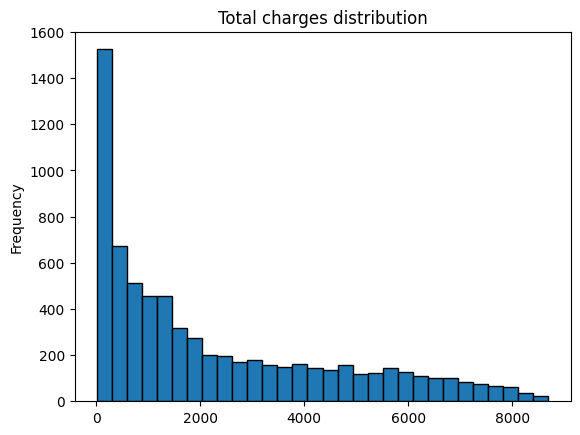

In [16]:
df['totalcharges'].plot.hist(bins=30, edgecolor='black')
plt.title("Total charges distribution")

### Feature Corelation Heatmap

In [17]:
df.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn', 'tenuregroup',
       'monthlychargepertenure'],
      dtype='object')

In [18]:
df_encoded.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'paperlessbilling', 'monthlycharges', 'totalcharges',
       'churn', 'monthlychargepertenure', 'multiplelines_No phone service',
       'multiplelines_Yes', 'internetservice_Fiber optic',
       'internetservice_No', 'onlinesecurity_No internet service',
       'onlinesecurity_Yes', 'onlinebackup_No internet service',
       'onlinebackup_Yes', 'deviceprotection_No internet service',
       'deviceprotection_Yes', 'techsupport_No internet service',
       'techsupport_Yes', 'streamingtv_No internet service', 'streamingtv_Yes',
       'streamingmovies_No internet service', 'streamingmovies_Yes',
       'contract_One year', 'contract_Two year',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'tenuregroup_Loyal', 'tenuregroup_New'],
      dtype='object')

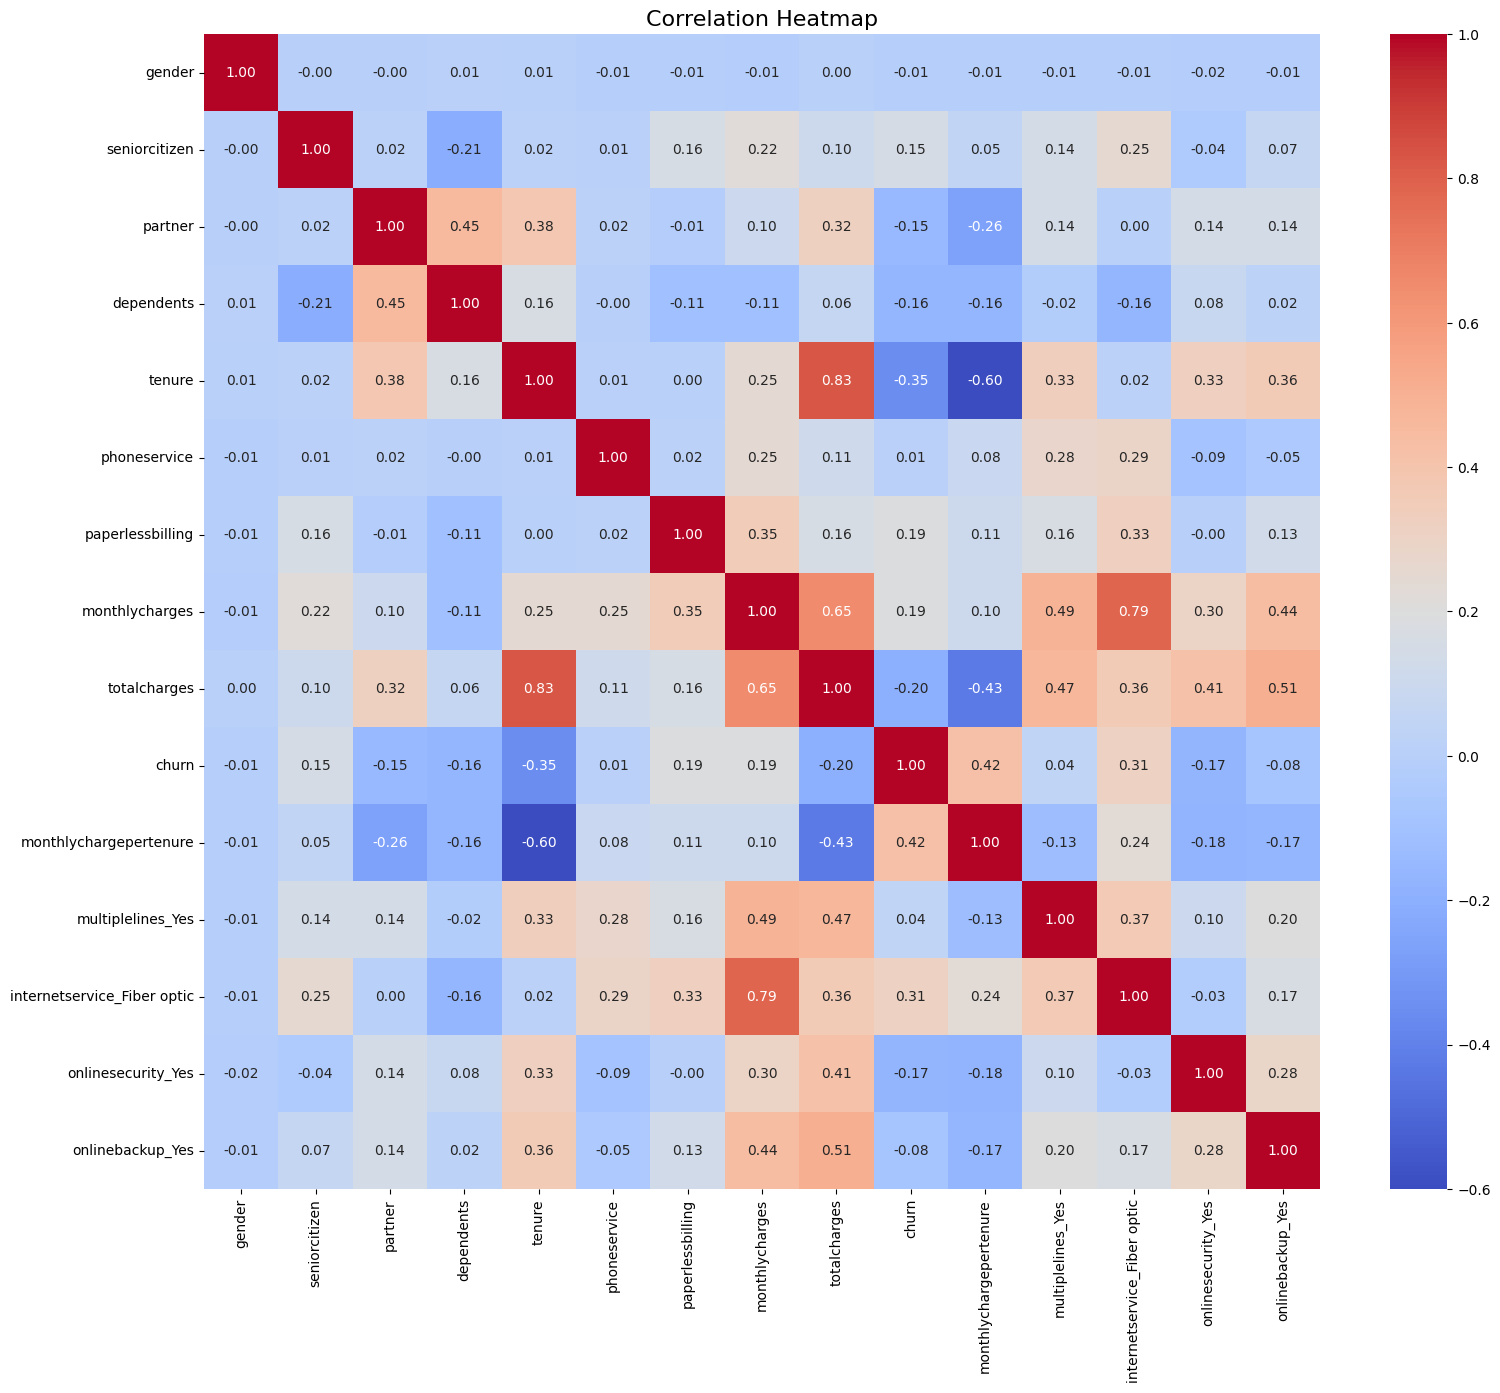

In [71]:
df_heat = df_encoded.copy()
df_heat = df_heat.drop(['internetservice_No','onlinesecurity_No internet service','onlinebackup_No internet service','deviceprotection_No internet service','deviceprotection_Yes', 'techsupport_No internet service',
       'techsupport_Yes', 'streamingtv_No internet service', 'streamingtv_Yes',
       'streamingmovies_No internet service', 'streamingmovies_Yes','multiplelines_No phone service','streamingmovies_No internet service', 'streamingmovies_Yes',
       'contract_One year', 'contract_Two year',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'tenuregroup_Loyal', 'tenuregroup_New'], axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(df_heat.corr(numeric_only=True) , cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Heatmap",fontsize=16)
plt.xticks(rotation=90)
plt.show()

df_heat.to_csv("df_for_heatmap.csv", index=False)

### Pie plot for churn

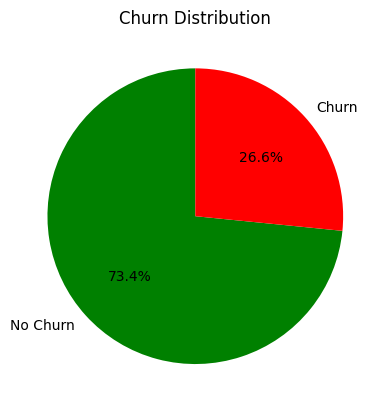

In [20]:
plt.pie(df['churn'].value_counts(), 
        colors=['green', 'red'],
        labels=['No Churn', 'Churn'], 
        autopct='%1.1f%%', 
        startangle=90)
plt.title("Churn Distribution")
plt.show()

### **Univariate analysis(Count Plots)**

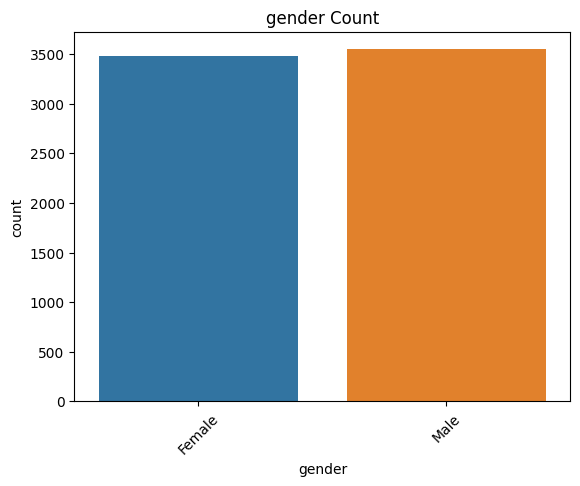

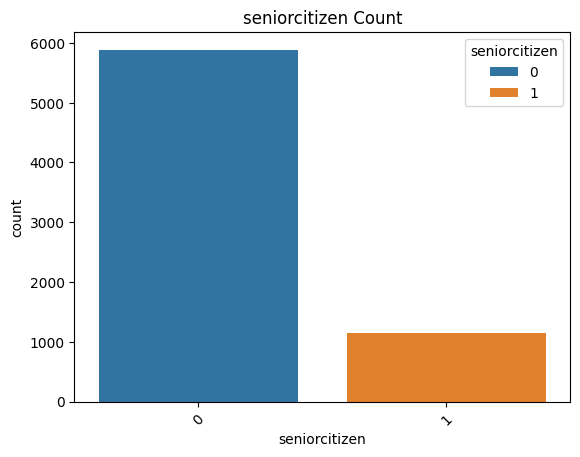

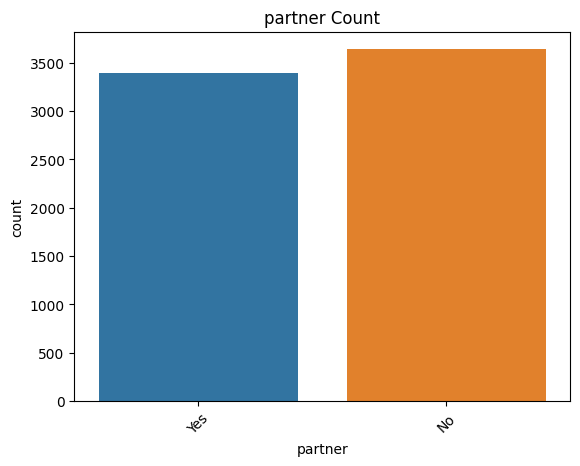

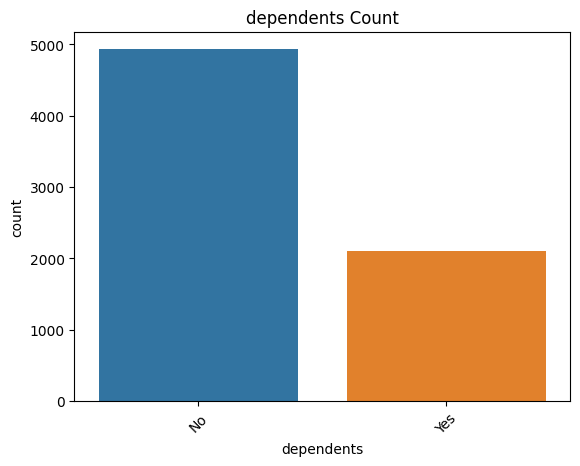

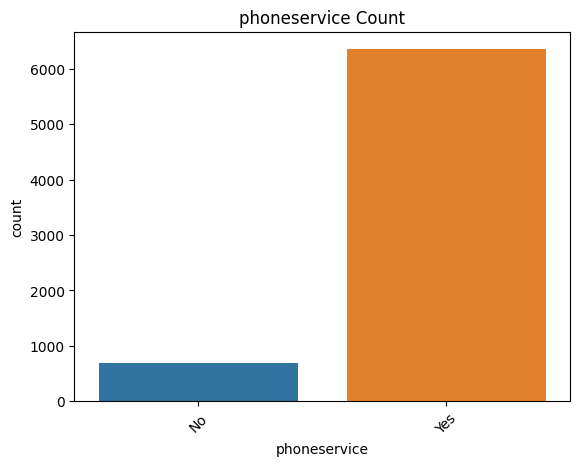

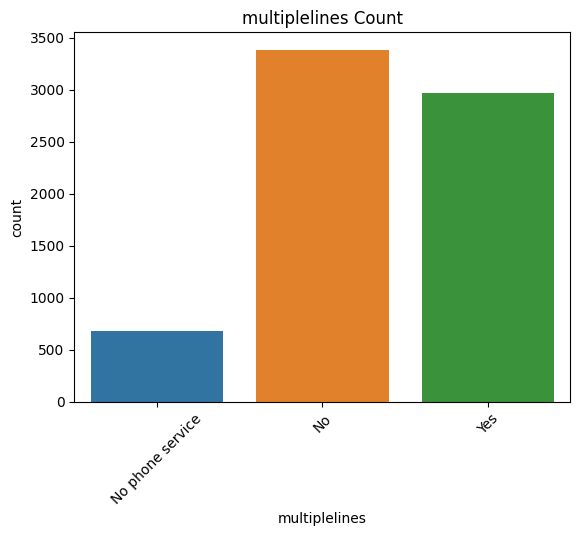

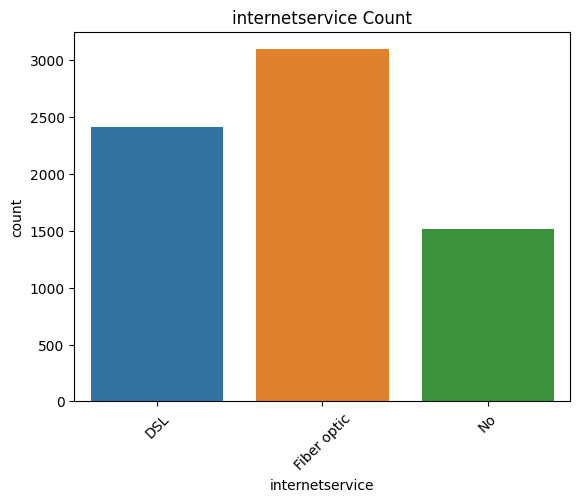

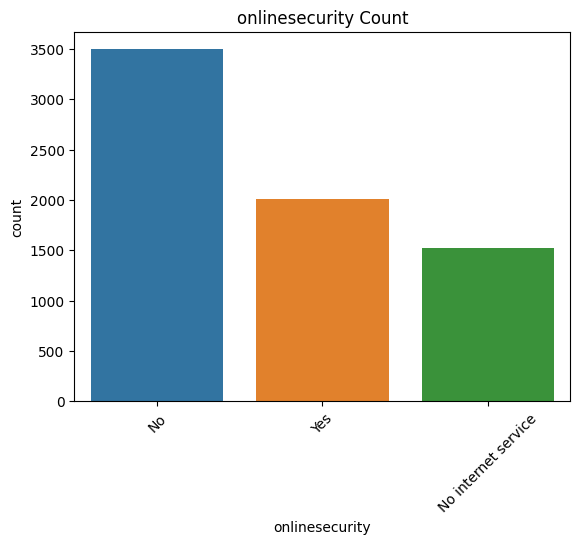

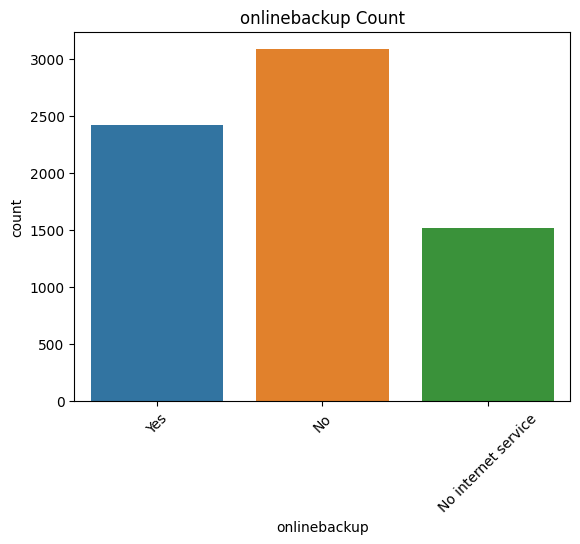

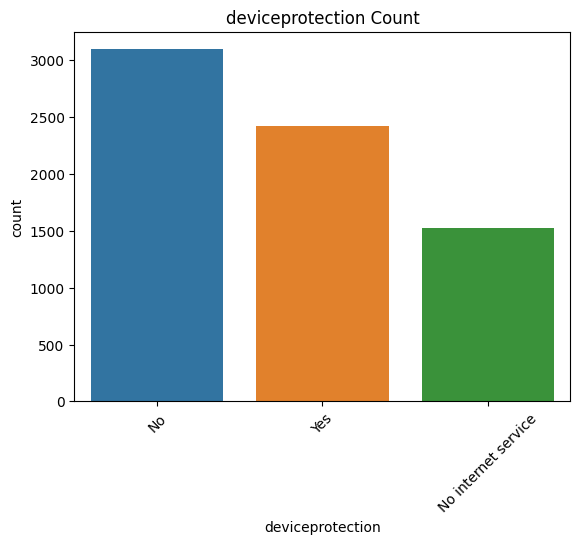

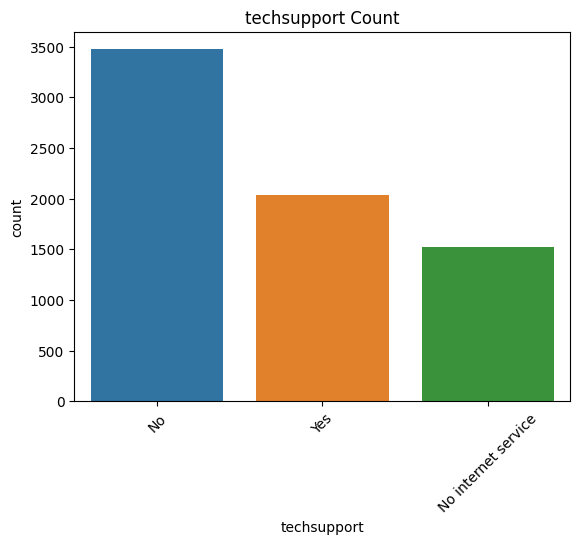

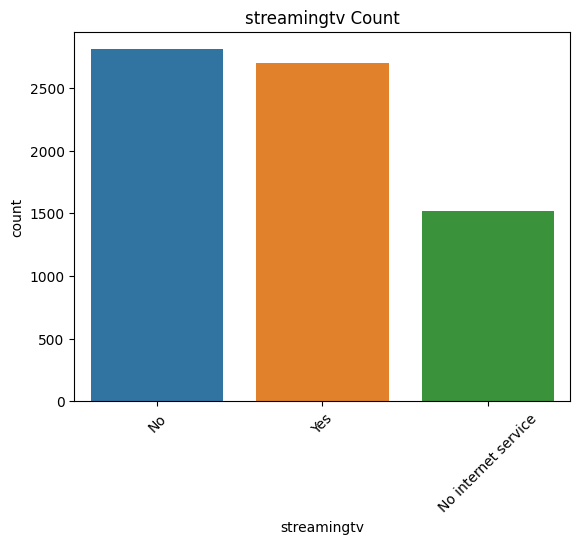

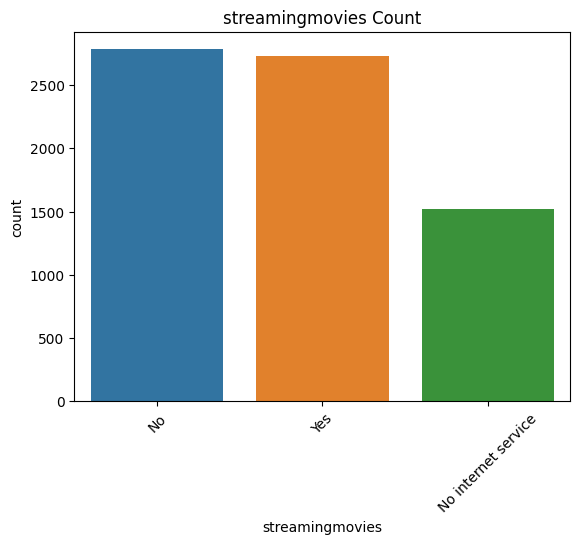

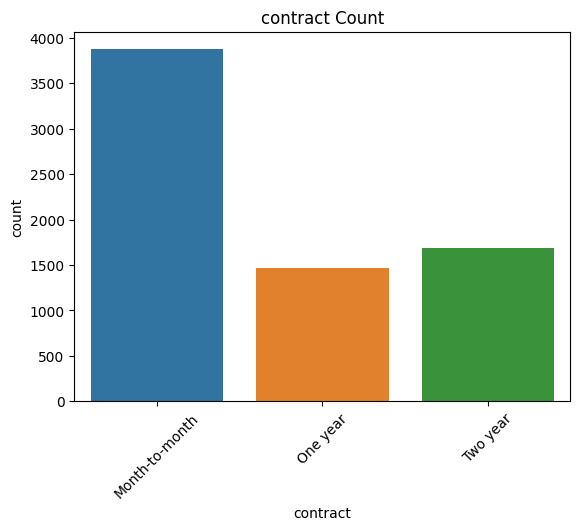

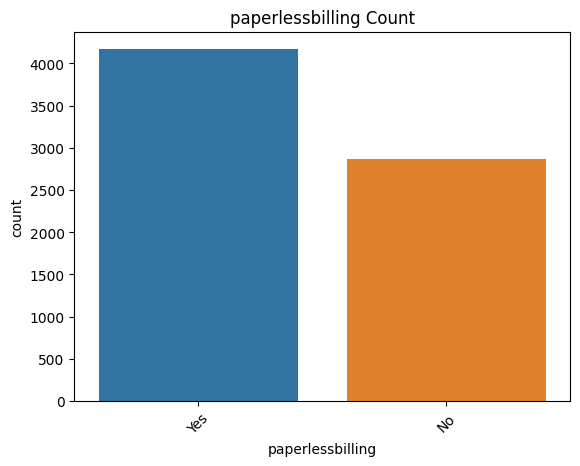

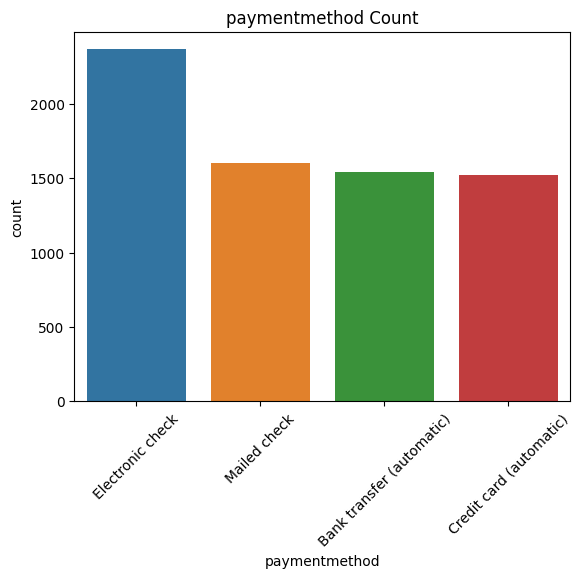

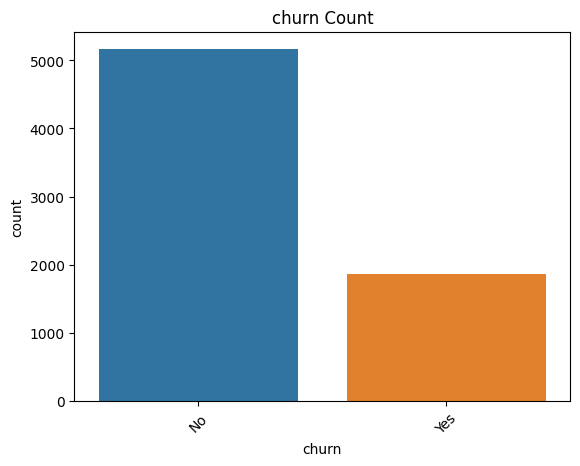

In [21]:
for col in ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
            'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
            'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
            'contract', 'paperlessbilling', 'paymentmethod', 'churn']:
    sns.countplot(x=col, data=df,hue=col)
    plt.xticks(rotation=45)
    plt.title(f'{col} Count')
    plt.show()

### **Bivariate analysis** 

#### Histogram/ KDE plots

<Axes: xlabel='monthlycharges', ylabel='Density'>

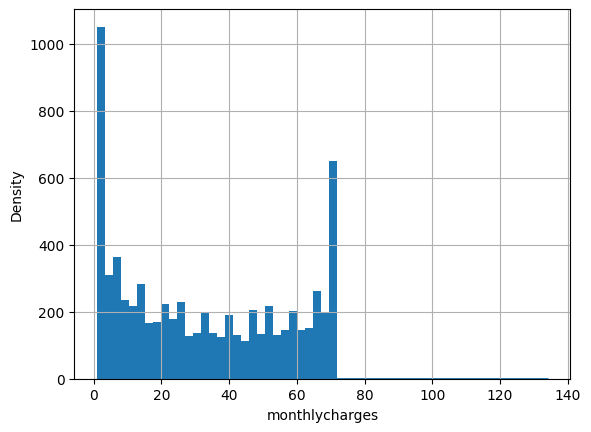

In [22]:
df['tenure'].hist(bins=30)
sns.kdeplot(df['monthlycharges'], fill=True)

### Bivariate Analysis (Relationship with churn)

In [23]:
#### Partner 

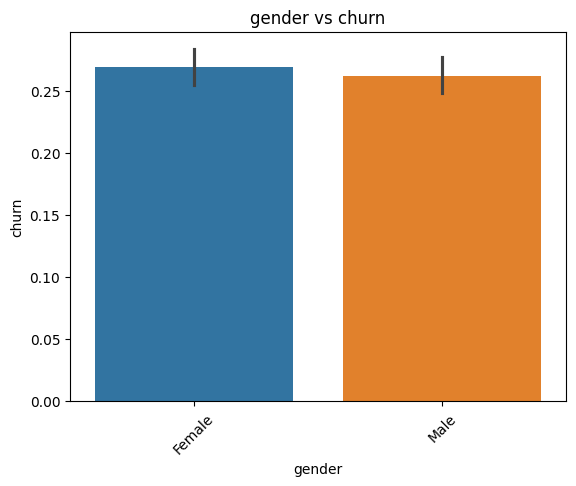

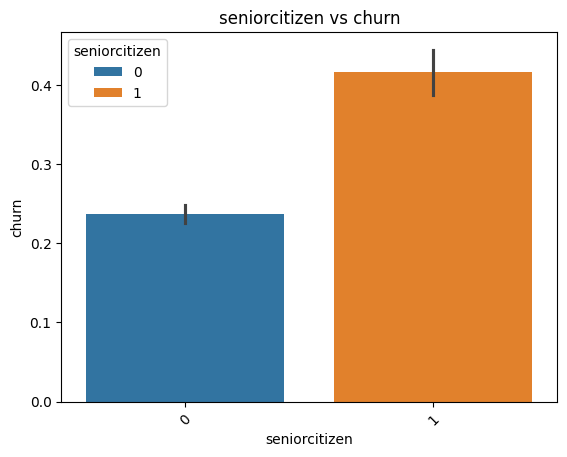

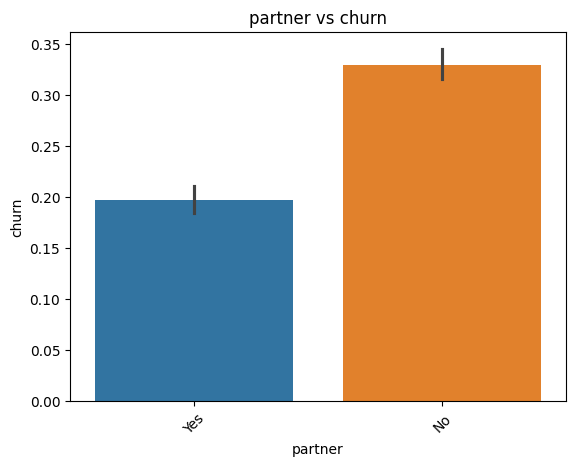

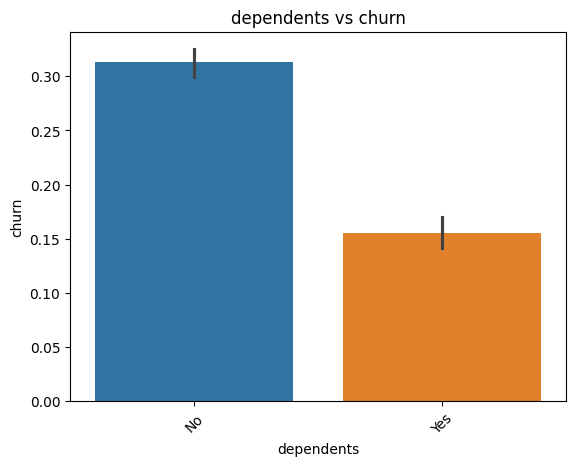

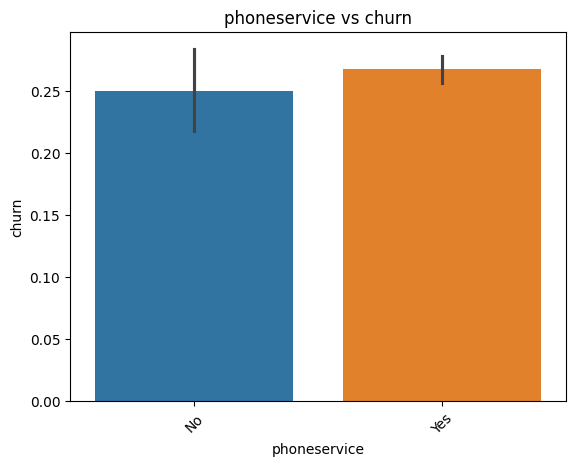

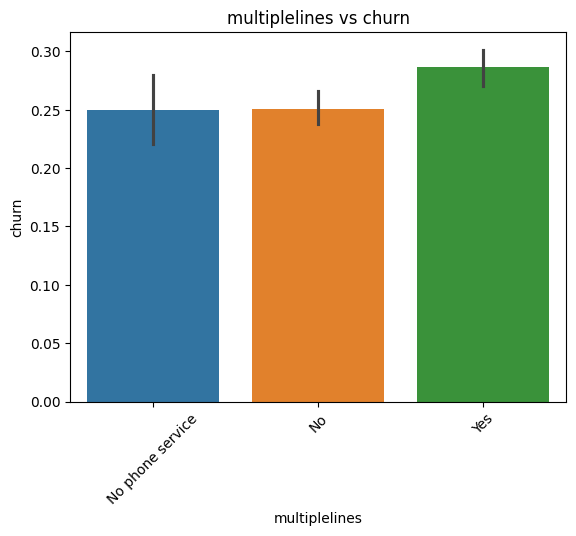

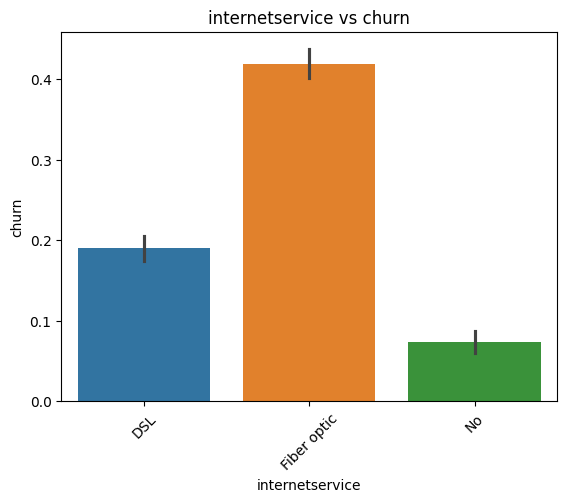

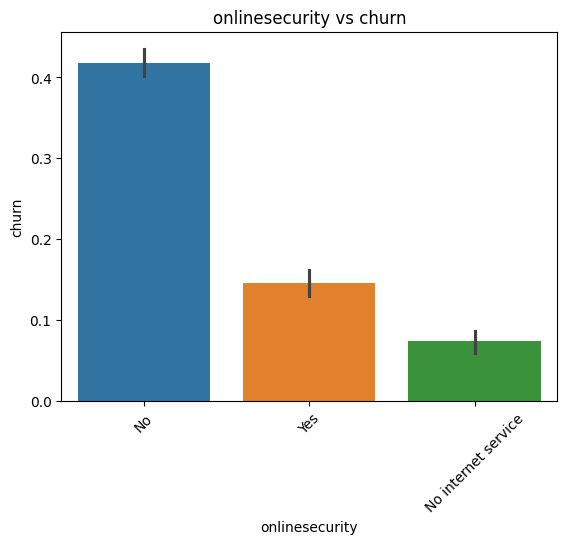

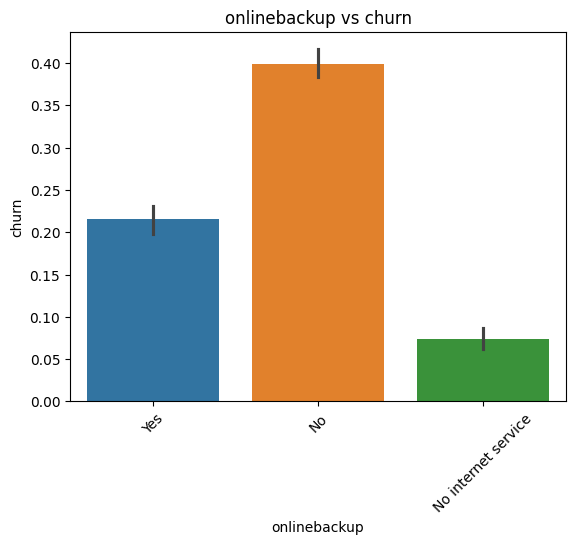

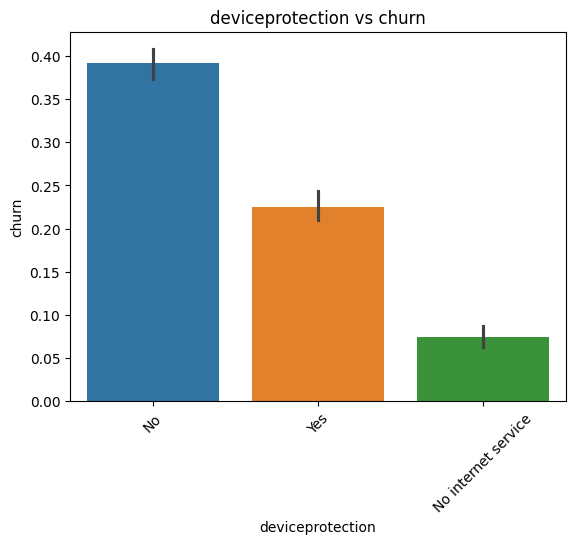

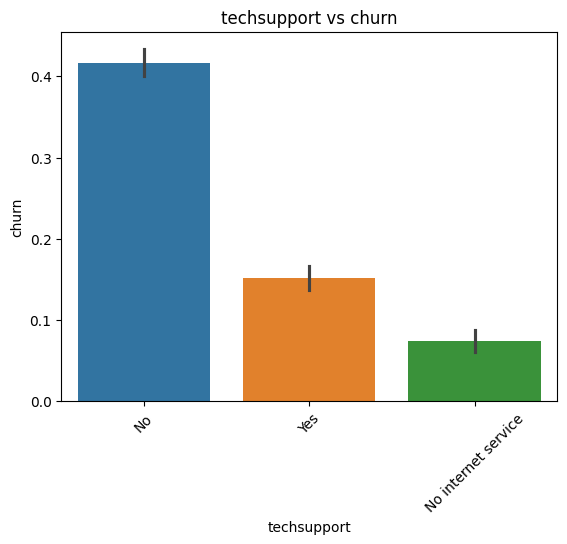

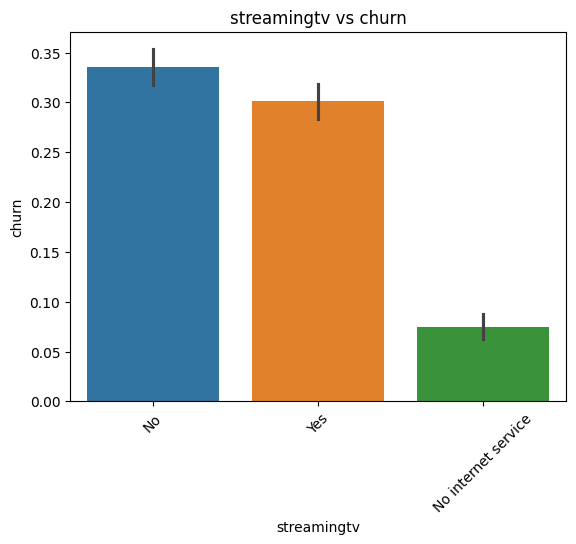

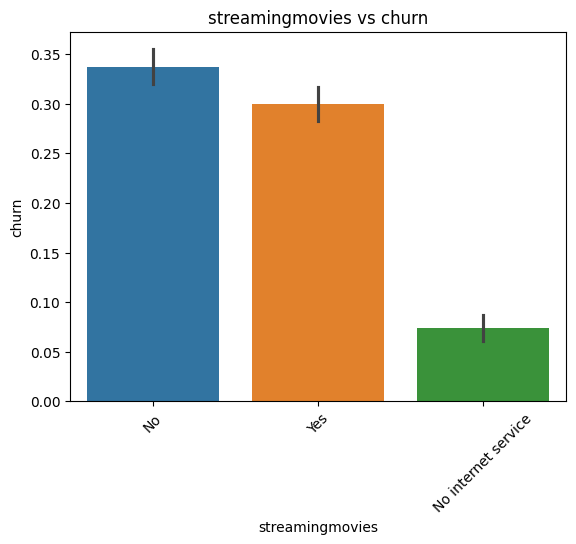

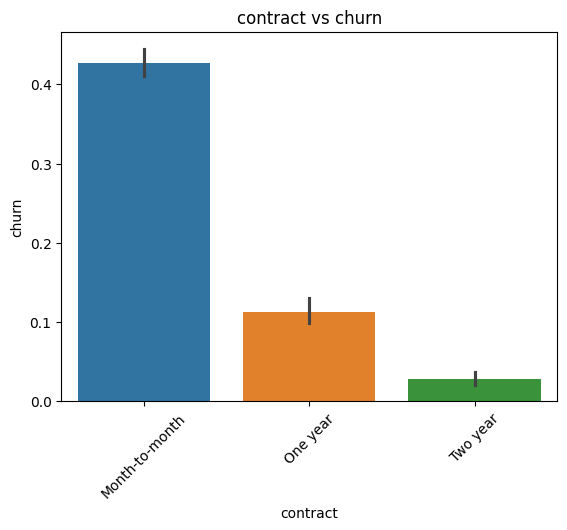

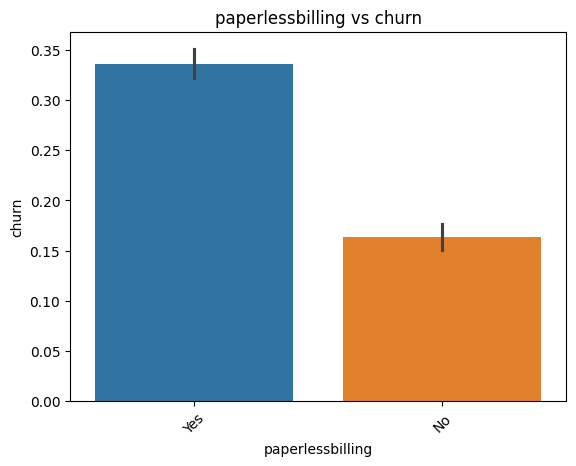

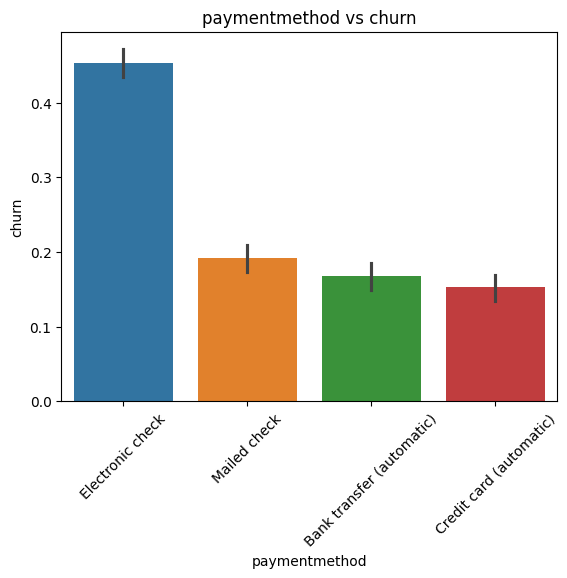

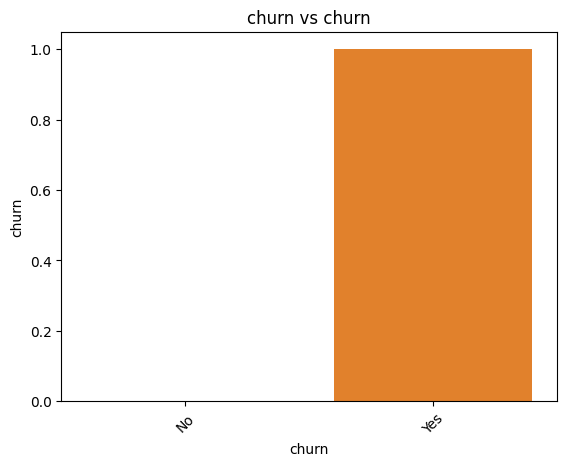

In [24]:
for col in ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
            'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
            'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
            'contract', 'paperlessbilling', 'paymentmethod', 'churn']:
    sns.barplot(x=col, y=df_encoded['churn'] ,data=df,hue=col)
    plt.xticks(rotation=45)
    plt.title(f'{col} vs churn')
    plt.show()

<Axes: xlabel='partner', ylabel='count'>

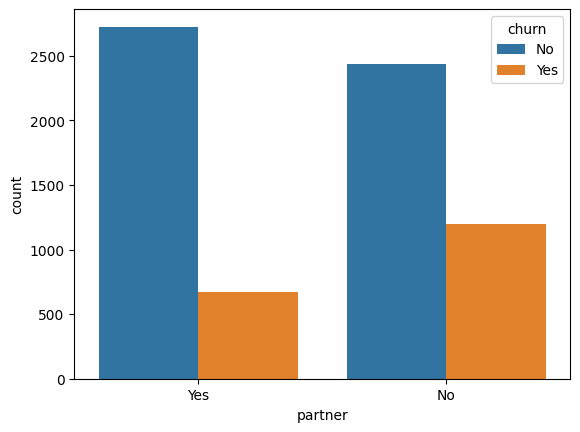

In [25]:
sns.countplot(x='partner', hue='churn', data=df)

### Box plot

<Axes: xlabel='churn', ylabel='monthlycharges'>

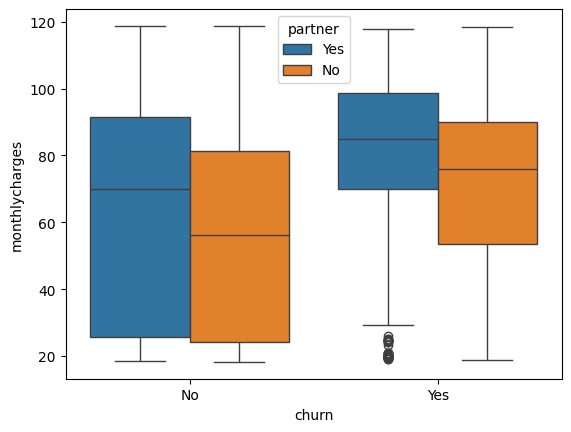

In [26]:
sns.boxplot(x='churn', y='monthlycharges', data=df, hue='partner')

### Violin Plot

<Axes: xlabel='churn', ylabel='tenure'>

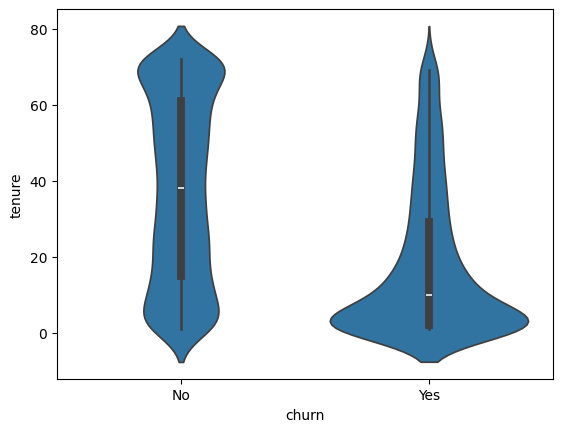

In [27]:
sns.violinplot(x='churn', y='tenure', data=df)

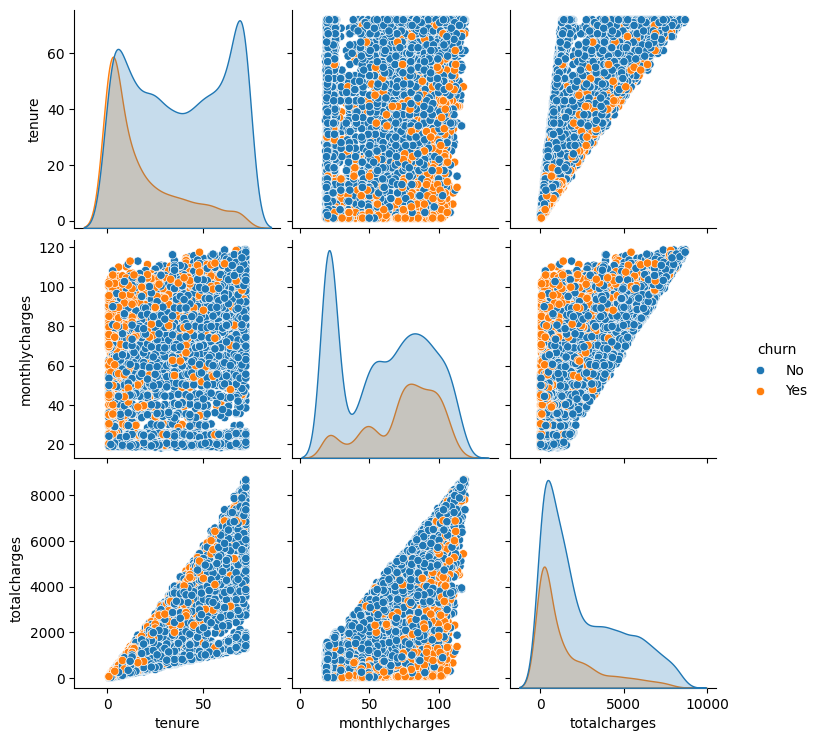

In [28]:
sns.pairplot(df[['tenure', 'monthlycharges', 'totalcharges', 'churn']], hue='churn')


In [29]:
df_encoded.dtypes

gender                                     int64
seniorcitizen                              int64
partner                                    int64
dependents                                 int64
tenure                                     int64
phoneservice                               int64
paperlessbilling                           int64
monthlycharges                           float64
totalcharges                             float64
churn                                      int64
monthlychargepertenure                   float64
multiplelines_No phone service              bool
multiplelines_Yes                           bool
internetservice_Fiber optic                 bool
internetservice_No                          bool
onlinesecurity_No internet service          bool
onlinesecurity_Yes                          bool
onlinebackup_No internet service            bool
onlinebackup_Yes                            bool
deviceprotection_No internet service        bool
deviceprotection_Yes

> ### Model on unbalanced data

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['churn'], axis = 1)
y = df_encoded['churn']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42, stratify=y)
model_rf = RandomForestClassifier(n_estimators=150, class_weight='balanced').fit(X_train,y_train)
model_rf

RandomForestClassifier(class_weight='balanced', n_estimators=150)

> ### SMOTE & class comparison

In [31]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: churn
0    3614
1    1308
Name: count, dtype: int64
After SMOTE: churn
1    3614
0    3614
Name: count, dtype: int64


> ### Model on SMOTEd Data

In [32]:
# X = df_encoded.drop(['churn'], axis = 1)
# y = df_encoded['churn']

# X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42, stratify=y)
model_rf_1 = RandomForestClassifier(n_estimators=150, class_weight='balanced').fit(X_train_res,y_train_res)
model_rf_1

RandomForestClassifier(class_weight='balanced', n_estimators=150)

In [33]:
y_pred_bal = model_rf_1.predict(X_test)
y_pred_un_bal = model_rf.predict(X_test)

>### Evaluation of Un-SMOTEd data

In [34]:
print(classification_report(y_test,y_pred_un_bal))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1549
           1       0.62      0.47      0.53       561

    accuracy                           0.78      2110
   macro avg       0.72      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110



In [35]:
cm_un_bal = confusion_matrix(y_test, y_pred_un_bal)
cm_un_bal

array([[1387,  162],
       [ 297,  264]])

<Axes: >

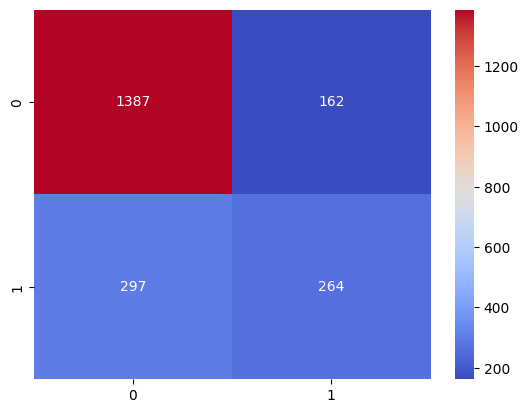

In [36]:
sns.heatmap(cm_un_bal, annot=True, fmt='d', cmap='coolwarm')

In [37]:
accuracy = model_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 78.25%


> ### Evaluation of SMOTEd data

In [38]:
print(classification_report(y_test,y_pred_bal))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1549
           1       0.57      0.58      0.58       561

    accuracy                           0.77      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.77      0.77      0.77      2110



In [39]:
cm_bal = confusion_matrix(y_test, y_pred_bal)
cm_bal

array([[1302,  247],
       [ 233,  328]])

Text(0.5, 1.0, 'Confusion Matrix of RFClassifier')

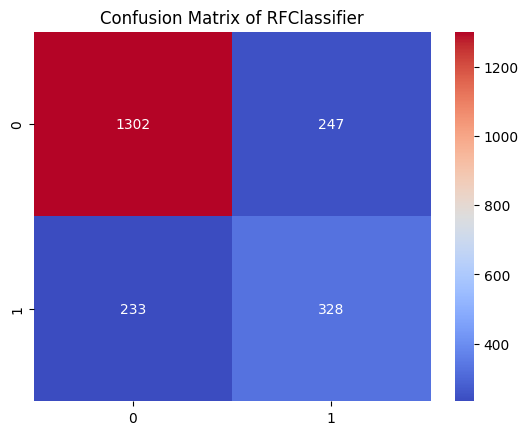

In [40]:
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix of RFClassifier")

In [41]:
accuracy = model_rf_1.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 77.25%


> ### Feature Importance

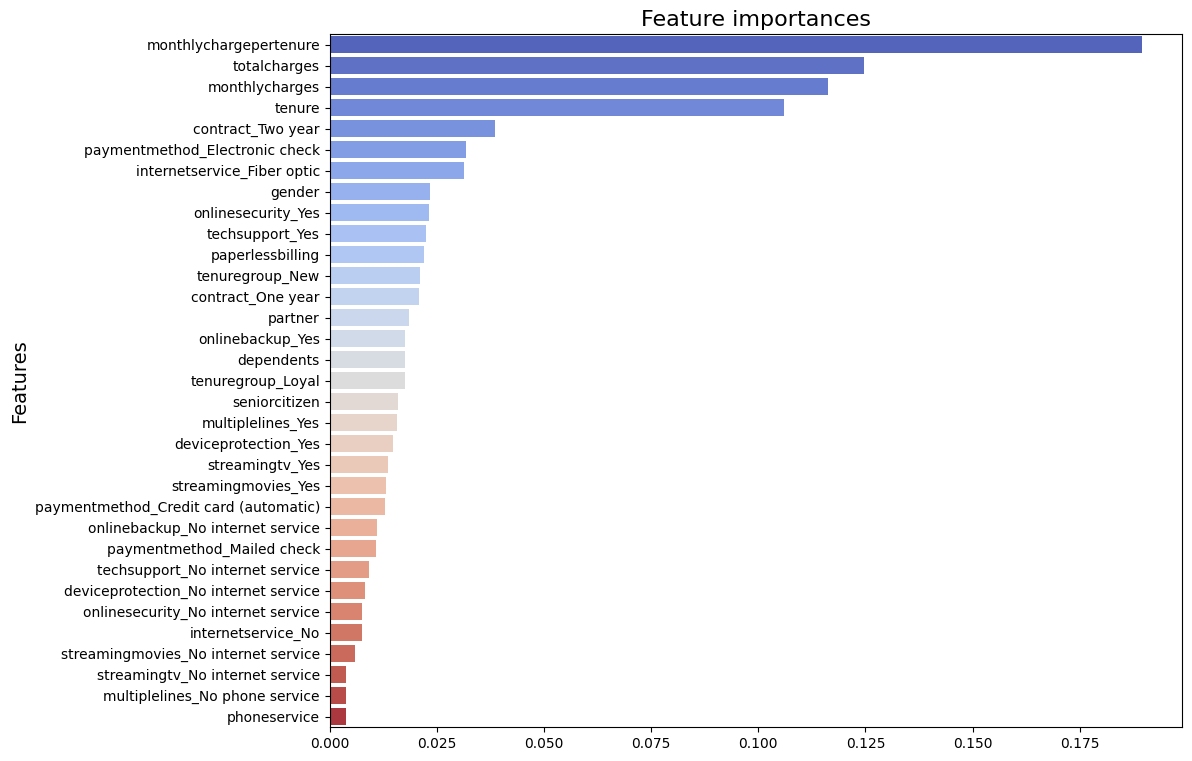

In [ ]:
features = X_train.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
colors = sns.color_palette("coolwarm", len(indices))
plt.figure(figsize=(11,9))
plt.title("Feature importances", fontsize= 16)
plt.ylabel("Features", fontsize=14)
sns.barplot(x=importances[indices], y=features[indices], palette=colors, hue=features[indices], legend=False)
plt.show()

> ### **XGBoost**

In [43]:
modelXG = XGBClassifier(eval_metric='logloss', n_estimators=1000, learning_rate=0.01, max_depth=5, scale_pos_weight=1).fit(X_train_res, y_train_res)
modelXG

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [44]:
y_pred_xg = modelXG.predict(X_test)

# Evaluation
acc_xg = accuracy_score(y_test, y_pred_xg)
cm_xg = confusion_matrix(y_test, y_pred_xg)
print(f"Accuracy: {acc_xg*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xg))
print(f"\nConfusion Matrix: \n{cm_xg}\n")

Accuracy: 76.59%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1549
           1       0.55      0.62      0.58       561

    accuracy                           0.77      2110
   macro avg       0.70      0.72      0.71      2110
weighted avg       0.78      0.77      0.77      2110


Confusion Matrix: 
[[1270  279]
 [ 215  346]]



Text(0.5, 1.0, 'Confusion Matrix of XGBoost')

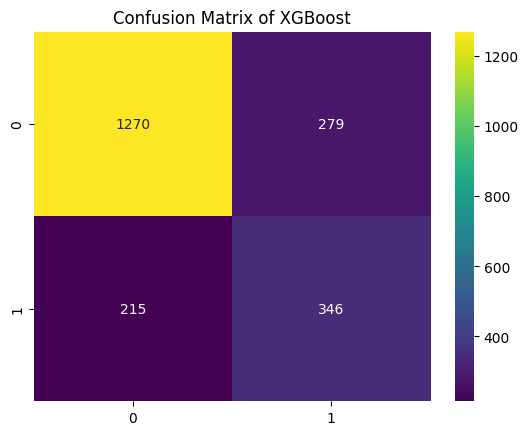

In [45]:
sns.heatmap(cm_xg, cmap='viridis', annot=True, fmt='d')
plt.title("Confusion Matrix of XGBoost")

> ### Predictions

In [46]:
threshold = 0.37
y_prob_bal = model_rf_1.predict_proba(X_test)[:, 1]  # Probabilities for class 1

In [47]:
for i in range(9):
    print(f"Customer {i+1}: Churn Probability = {y_prob_bal[i]:.2f}, Predicted Class = {y_pred_bal[i]}")

Customer 1: Churn Probability = 0.07, Predicted Class = 0
Customer 2: Churn Probability = 0.23, Predicted Class = 0
Customer 3: Churn Probability = 0.08, Predicted Class = 0
Customer 4: Churn Probability = 0.09, Predicted Class = 0
Customer 5: Churn Probability = 0.04, Predicted Class = 0
Customer 6: Churn Probability = 0.43, Predicted Class = 0
Customer 7: Churn Probability = 0.19, Predicted Class = 0
Customer 8: Churn Probability = 0.03, Predicted Class = 0
Customer 9: Churn Probability = 0.00, Predicted Class = 0


In [48]:
threshold = 0.37
y_prob_xg = modelXG.predict_proba(X_test)[:, 1]

In [49]:
# Example custom customer
custom_data = pd.DataFrame([{
    'gender': 1,
    'seniorcitizen': 0,
    'partner': 0,
    'dependents': 0,
    'tenure': 2,
    'phoneservice': 1,
    'paperlessbilling': 1,
    'monthlycharges': 53.85,
    'totalcharges': 108.15,
    # 'monthlychargepertenure': 70.5 / (6 + 1),
    'monthlychargepertenure': 17.95,

    # One-hot encoded columns — use 1 for the applicable one, 0 for others
    'multiplelines_No phone service': 0,
    'multiplelines_Yes': 0,

    'internetservice_Fiber optic': 0,
    'internetservice_No': 0,

    'onlinesecurity_No internet service': 0,
    'onlinesecurity_Yes': 1,

    'onlinebackup_No internet service': 0,
    'onlinebackup_Yes': 1,

    'deviceprotection_No internet service': 0,
    'deviceprotection_Yes': 0,

    'techsupport_No internet service': 0,
    'techsupport_Yes': 0,

    'streamingtv_No internet service': 0,
    'streamingtv_Yes': 1,

    'streamingmovies_No internet service': 0,
    'streamingmovies_Yes': 0,

    'contract_One year': 0,
    'contract_Two year': 0,

    'paymentmethod_Credit card (automatic)': 0,
    'paymentmethod_Electronic check': 0,
    'paymentmethod_Mailed check': 1,

    'tenuregroup_Loyal': 0,
    'tenuregroup_New': 0
}])


### Prediction of RFClassifier

In [50]:
pred_xg = modelXG.predict(custom_data)
pred_xg

churn_prob_xg = model_rf_1.predict_proba(custom_data)[0][1]

# Prediction using custom threshold
threshold = 0.37
predicted_class = int(churn_prob_xg > threshold)

print(f"Churn Probability (XGBoost): {churn_prob_xg*100:.2f}%")
print(f"Predicted Class by XGBoost: {predicted_class}")

Churn Probability (XGBoost): 68.67%
Predicted Class by XGBoost: 1


#### Prediction of XGBoost

In [51]:
# Probability of churn
churn_prob_rf = model_rf_1.predict_proba(custom_data)[0][1]

# Prediction using custom threshold
threshold = 0.37
predicted_class = int(churn_prob_rf > threshold)

print(f"Churn Probability (RFClassifier): {churn_prob_rf*100:.2f}%")
print(f"Predicted Class by RFClassifier: {predicted_class}")

Churn Probability (RFClassifier): 68.67%
Predicted Class by RFClassifier: 1


### Comparing Actual vs predicted values

In [52]:
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Class': y_pred_xg,
    'Churn_Probability': y_prob_xg
})

print(comparison_df.head(10))

   Actual  Predicted_Class  Churn_Probability
0       0                0           0.105201
1       0                0           0.315305
2       0                0           0.043371
3       0                0           0.042435
4       0                0           0.064285
5       0                0           0.370602
6       0                0           0.148429
7       0                0           0.138498
8       0                0           0.020467
9       1                0           0.047862


In [53]:
custom_threshold = 0.37
y_pred_custom = (y_prob_bal >= custom_threshold).astype(int)

In [54]:
print(confusion_matrix(y_test, y_pred_custom))

[[1147  402]
 [ 155  406]]


In [55]:
from sklearn.metrics import classification_report, roc_auc_score, auc

print(classification_report(y_test, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_bal))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1549
           1       0.50      0.72      0.59       561

    accuracy                           0.74      2110
   macro avg       0.69      0.73      0.70      2110
weighted avg       0.78      0.74      0.75      2110

ROC-AUC Score: 0.8023179810101163


In [56]:
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Class': y_pred_custom,
    'Churn_Probability': y_prob_bal
})

print(comparison_df.head(20))

    Actual  Predicted_Class  Churn_Probability
0        0                0           0.073333
1        0                0           0.233333
2        0                0           0.080000
3        0                0           0.086667
4        0                0           0.040000
5        0                1           0.433333
6        0                0           0.193333
7        0                0           0.033333
8        0                0           0.000000
9        1                0           0.053333
10       0                0           0.306667
11       0                0           0.233333
12       0                0           0.106667
13       1                0           0.146667
14       0                0           0.080000
15       0                0           0.013333
16       1                0           0.213333
17       0                1           0.426667
18       0                0           0.266667
19       1                1           0.420000


### PR curve RFClassifier

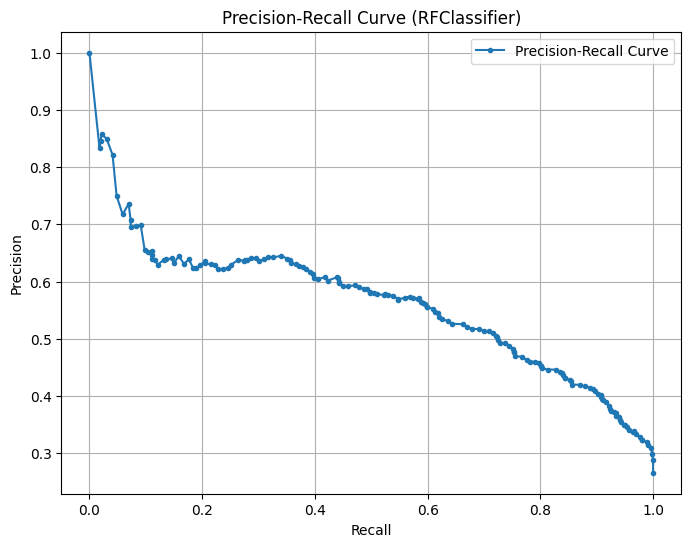

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_bal)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (RFClassifier)')
plt.grid(True)
plt.legend()
plt.show()

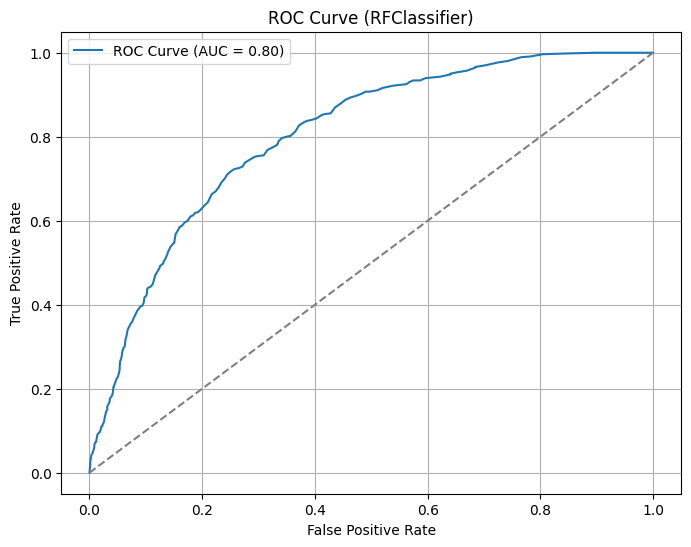

In [58]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_bal)
roc_auc = roc_auc_score(y_test, y_prob_bal)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RFClassifier)')             
plt.grid(True)
plt.legend()
plt.show()

In [59]:
f1_scores = [f1_score(y_test, y_prob_bal >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold (max F1): {best_threshold:.2f}")

Best threshold (max F1): 0.39


### PR curve XGBoost

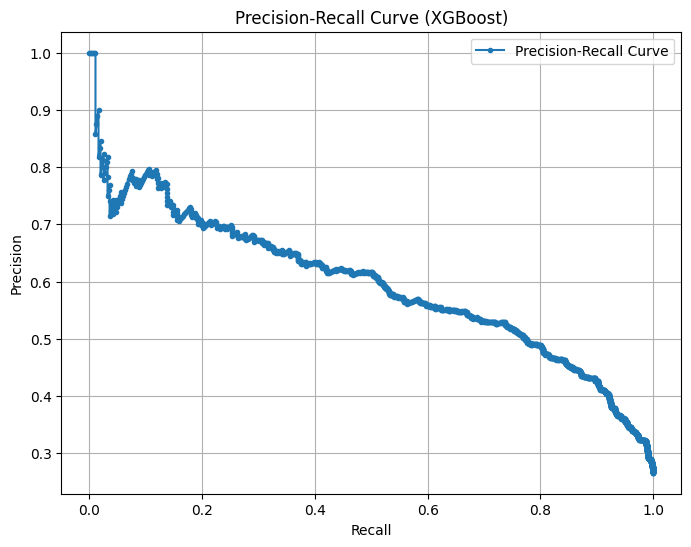

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xg)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker = '.', label = "Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.grid(True)
plt.legend()
plt.show()

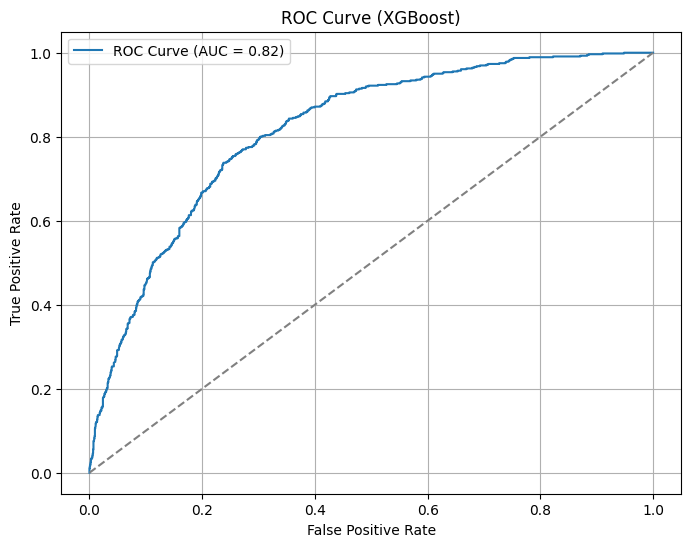

In [61]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_xg)
roc_auc = roc_auc_score(y_test, y_prob_xg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label = f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

### Saving Models

In [62]:
import joblib
joblib.dump(model_rf_1, 'model_rf.pkl')

['model_rf.pkl']

In [63]:
model_rf = joblib.load('model_rf.pkl')
model_predictions = model_rf_1.predict(X_test)
model_predictions

array([0, 0, 0, ..., 0, 0, 1], shape=(2110,))

In [64]:
joblib.dump(modelXG, 'model_xg.pkl')

['model_xg.pkl']

In [65]:
modelXG = joblib.load('model_xg.pkl')
modelXG_pred = modelXG.predict(X_test)
modelXG_pred

array([0, 0, 0, ..., 0, 0, 1], shape=(2110,))

>### What-if charges are reduced by 20%

In [66]:
X_test_copy = X_test.copy()

# Reduce monthlycharges and totalcharges by 20%
X_test_copy['monthlycharges'] *= 0.8
X_test_copy['totalcharges'] *= 0.8  # if applicable

In [67]:
# Predict original churn probabilities
original_probs = modelXG.predict_proba(X_test)[:, 1]

# Predict churn probabilities after reducing charges
reduced_probs = modelXG.predict_proba(X_test_copy)[:, 1]

In [68]:
original_avg = np.mean(original_probs)
reduced_avg = np.mean(reduced_probs)

print(f"Original Avg Churn Probability: {original_avg:.4f}")
print(f"Reduced Charges Avg Churn Probability: {reduced_avg:.4f}")
print(f"Change: {original_avg - reduced_avg:.4f}")

Original Avg Churn Probability: 0.3246
Reduced Charges Avg Churn Probability: 0.4146
Change: -0.0901


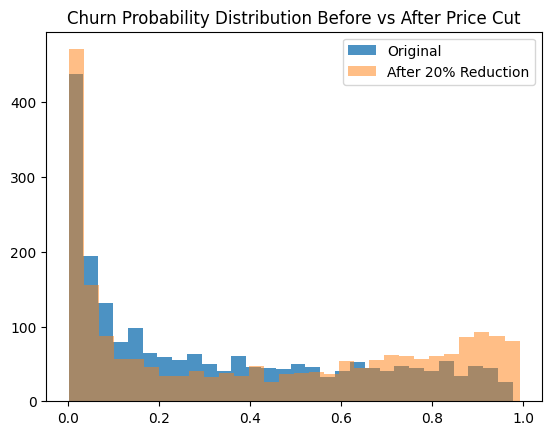

In [69]:
plt.hist(original_probs, bins=30, alpha=0.8, label='Original')
plt.hist(reduced_probs, bins=30, alpha=0.5, label='After 20% Reduction')
plt.legend()
plt.title("Churn Probability Distribution Before vs After Price Cut")
plt.show()